# Coursera IBM Data Science Capstone - Opening a new  McDonald's franchise in CABA, Argentina

First of all im going to import all the libraries that i'm going to use through the analisis. 
*if this line of code returns an error associated to folium you need to run the command !pip install folium above.*

In [1]:
!pip install folium
!pip install geocoder

     |████████████████████████████████| 92kB 19.1MB/s eta 0:00:01
     |████████████████████████████████| 102kB 6.9MB/s ta 0:00:011


In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## First Part: Reading and transforming the wikipedia table.

I found this usefull pandas function that can read through html and look for tables in the wikipedia page we pass as the url.

In [3]:
url = 'https://es.wikipedia.org/wiki/Anexo:Barrios_de_la_ciudad_de_Buenos_Aires'
df_wiki = pd.read_html(url, attrs={"class": "wikitable"})[0] # 0 is for the 1st table in this particular page. In fact, this page only has one table.
df_wiki.head()

,Nombre del barrio,Superficie[1]​,Habitantes (año 2007),Densidad de habitantes (año 2007),Comuna de pertenencia de la Ciudad de Buenos Aires
0,Agronomía,"2,1 km²",34.580,8.645,Comuna 15
1,Almagro,"4,1 km²",139.262,33.960,Comuna 5
2,Balvanera,"4,4 km²",152.198,34.950,Comuna 3
3,Barracas,"7,6 km²",77.474,10.194,Comuna 4
4,Belgrano,"6,8 km²",138.942,20.433,Comuna 13


In [4]:
df_wiki.shape

(48, 5)

I was only gona keep the neighborhood column but i will also keep the density of population because i think it can be usefull. The rest of the columns i'll drop them.

In [5]:
df_wiki = df_wiki.drop(columns=['Comuna de pertenencia de la Ciudad de Buenos Aires','Habitantes (año 2007)','Superficie[1]​'])
df_wiki.head()

,Nombre del barrio,Densidad de habitantes (año 2007)
0,Agronomía,8.645
1,Almagro,33.960
2,Balvanera,34.950
3,Barracas,10.194
4,Belgrano,20.433


Next, im changing the name of the columns from spanish to english.

In [6]:
df_wiki.rename(columns={'Nombre del barrio':'Neighborhood','Densidad de habitantes (año 2007)':'Population Density'}, inplace=True)
df_wiki.head()

,Neighborhood,Population Density
0,Agronomía,8.645
1,Almagro,33.960
2,Balvanera,34.950
3,Barracas,10.194
4,Belgrano,20.433


## Second Part: Getting the latitude and longitudes values with geocoder and merging them with de wikipedia table.

In [7]:
def get_latlng(Neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Buenos Aires, Argentina'.format(Neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

Using the get_latlng function to look for the coordenates of the neighborhoods and storing them in a list

In [8]:
coords = [get_latlng(Neighborhood) for Neighborhood in df_wiki["Neighborhood"].tolist()]
coords

[[-34.59242999999998, -58.49658999999997],
 [-34.60323999999997, -58.42042999999995],
 [-34.61010999999996, -58.406019999999955],
 [-34.649899999999946, -58.389099999999985],
 [-34.56152999999995, -58.45701999999994],
 [-34.63227999999998, -58.41778999999997],
 [-34.62261999999998, -58.44621999999998],
 [-34.58350999999993, -58.45286999999996],
 [-34.561579999999935, -58.474279999999965],
 [-34.57501999999994, -58.447769999999934],
 [-34.62120999999996, -58.38654999999994],
 [-34.62871999999993, -58.461919999999964],
 [-34.628979999999956, -58.48158999999998],
 [-34.826219631360225, -58.19723281403767],
 [-34.60622999999998, -58.47555999999997],
 [-34.64394999999996, -58.517499999999984],
 [-34.65775999999994, -58.49927999999994],
 [-34.61350999999996, -58.38173999999998],
 [-34.61952999999994, -58.505349999999964],
 [-34.64987999999994, -58.42022999999995],
 [-34.55082999999996, -58.46655999999996],
 [-34.578179999999975, -58.425989999999956],
 [-34.64417999999995, -58.48332999999997]

Passing from list to df with pandas and merging it with the df_wiki.

In [9]:
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_coords.head()

,Latitude,Longitude
0,-34.59243,-58.49659
1,-34.60324,-58.42043
2,-34.61011,-58.40602
3,-34.64990,-58.38910
4,-34.56153,-58.45702


In [10]:
df_wiki['Latitude'] = df_coords['Latitude']
df_wiki['Longitude'] = df_coords['Longitude']
bsas_df = df_wiki
bsas_df.head()

,Neighborhood,Population Density,Latitude,Longitude
0,Agronomía,8.645,-34.59243,-58.49659
1,Almagro,33.960,-34.60324,-58.42043
2,Balvanera,34.950,-34.61011,-58.40602
3,Barracas,10.194,-34.64990,-58.38910
4,Belgrano,20.433,-34.56153,-58.45702


## Third Part: Getting the venues from foursquare and transforming it into a convenient df

In this lines of code we are ploting the remaining Neighborhood's in the map

In [11]:
address = 'Buenos Aires'

geolocator = Nominatim(user_agent="bue_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Buenos Aires are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Buenos Aires are -34.6075682, -58.4370894.


In [12]:
# create map of Toronto using latitude and longitude values
map_bsas = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(bsas_df['Latitude'], bsas_df['Longitude'], bsas_df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bsas)
    
map_bsas

Setting my foursquare credentials...

In [13]:
CLIENT_ID = '2TMDJ2L3IZ4HOPZNSZKYSFRCNZDIV2A3ZCFYTR3T5WW1TX00' # your Foursquare ID
CLIENT_SECRET = 'LVCTPLQXEB2HJGK2ISQFTNQSMDPXNLH4ZNTRLK2M5J3CEWGV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2TMDJ2L3IZ4HOPZNSZKYSFRCNZDIV2A3ZCFYTR3T5WW1TX00
CLIENT_SECRET:LVCTPLQXEB2HJGK2ISQFTNQSMDPXNLH4ZNTRLK2M5J3CEWGV


Next, i define the function getNearbyVenues that returns the nearby venues in a defined radius with a certain limit given the neighborhood, latitudes, longitudes.

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT = 100): #here i added the inpur LIMIT and i defined it as 100 as default
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Using the function...

In [18]:
bsas_venues = getNearbyVenues(names=bsas_df['Neighborhood'],
                                   latitudes=bsas_df['Latitude'],
                                   longitudes=bsas_df['Longitude']
                                  )

Agronomía
Almagro
Balvanera
Barracas
Belgrano
Boedo
Caballito
Chacarita
Coghlan
Colegiales
Constitución
Flores
Floresta
La Boca
La Paternal
Liniers
Mataderos
Montserrat
Monte Castro
Nueva Pompeya
Núñez
Palermo
Parque Avellaneda
Parque Chacabuco
Parque Chas
Parque Patricios
Puerto Madero
Recoleta
Retiro
Saavedra
San Cristóbal
San Nicolás
San Telmo
Vélez Sarsfield
Versalles
Villa Crespo
Villa del Parque
Villa Devoto
Villa Gral. Mitre
Villa Lugano
Villa Luro
Villa Ortúzar
Villa Pueyrredón
Villa Real
Villa Riachuelo
Villa Santa Rita
Villa Soldati
Villa Urquiza


As shown below the function also creates a new data frame including the venues information.

In [19]:
print(bsas_venues.shape)
bsas_venues.head()

(3335, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Agronomía,-34.59243,-58.49659,Baraba,-34.590674,-58.500094,Restaurant
1,Agronomía,-34.59243,-58.49659,Bien de Bien,-34.592322,-58.500959,Café
2,Agronomía,-34.59243,-58.49659,Ladobueno Patisserie & Café,-34.596536,-58.498617,Coffee Shop
3,Agronomía,-34.59243,-58.49659,Dorian Café & Bar,-34.587906,-58.493465,Café
4,Agronomía,-34.59243,-58.49659,Renatto Cucina Italiana,-34.591342,-58.500781,Italian Restaurant


Here i use the function group by and count to count the number of venues that each neighborhood has. 

In [20]:
bsas_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agronomía,81,81,81,81,81,81
Almagro,100,100,100,100,100,100
Balvanera,100,100,100,100,100,100
Barracas,18,18,18,18,18,18
Belgrano,100,100,100,100,100,100
Boedo,100,100,100,100,100,100
Caballito,100,100,100,100,100,100
Chacarita,100,100,100,100,100,100
Coghlan,100,100,100,100,100,100


In [21]:
print('There are {} uniques categories.'.format(len(bsas_venues['Venue Category'].unique())))

There are 228 uniques categories.


Here i use one hot encoding to transform categorical values into discrete ones by adding columns

In [22]:
# one hot encoding
bsas_onehot = pd.get_dummies(bsas_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bsas_onehot['Neighborhood'] = bsas_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bsas_onehot.columns[-1]] + list(bsas_onehot.columns[:-1])
bsas_onehot = bsas_onehot[fixed_columns]

bsas_onehot.head()

,Neighborhood,Accessories Store,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Football Field,College Gym,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fireworks Store,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Heliport,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Multiplex,Museum,Music Venue,Nature Preserve,Nightclub,Opera House,Other Great Outdoors,Outdoor Sculpture,Outlet Store,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,Racecourse,Racetrack,Recording Studio,Recreation Center,Restaurant,Rock Club,Rugby Pitch,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Science Museum,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Street Fair,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toll Booth,Toy / Game Store,Track,Trail,Train Station,Tunnel,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Agronomía,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Agronomía,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [23]:
bsas_onehot.shape

(3335, 229)

Using the mean to determine the freq of the venues in each neighborhood.

In [24]:
bsas_grouped = bsas_onehot.groupby('Neighborhood').mean().reset_index()
bsas_grouped.head()

,Neighborhood,Accessories Store,American Restaurant,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Basketball Court,Bed & Breakfast,Beer Bar,Beer Garden,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Buffet,Burger Joint,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Circus,Clothing Store,Cocktail Bar,Coffee Shop,College Football Field,College Gym,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Creperie,Cultural Center,Cupcake Shop,Dance Studio,Deli / Bodega,Dessert Shop,Dim Sum Restaurant,Diner,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fireworks Store,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,French Restaurant,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gourmet Shop,Government Building,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Heliport,Historic Site,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Juice Bar,Korean Restaurant,Latin American Restaurant,Light Rail Station,Liquor Store,Lounge,Market,Martial Arts Dojo,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Multiplex,Museum,Music Venue,Nature Preserve,Nightclub,Opera House,Other Great Outdoors,Outdoor Sculpture,Outlet Store,Paella Restaurant,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Store,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Playground,Plaza,Pool,Pool Hall,Print Shop,Pub,Public Art,Racecourse,Racetrack,Recording Studio,Recreation Center,Restaurant,Rock Club,Rugby Pitch,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Science Museum,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Club,Stadium,Steakhouse,Street Fair,Street Food Gathering,Supermarket,Sushi Restaurant,Swiss Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Toll Booth,Toy / Game Store,Track,Trail,Train Station,Tunnel,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Agronomía,0.0,0.0,0.0,0.061728,0.0,0.0,0.0,0.00,0.024691,0.0,0.0,0.000000,0.0,0.049383,0.0,0.0,0.024691,0.049383,0.0,0.00,0.012346,0.0,0.0,0.012346,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.037037,0.0,0.0,0.00,0.0,0.049383,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.000000,0.012346,0.074074,0.0,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.012346,0.00,0.0,0.0,0.0,0.012346,0.0,0.0,0.0,0.00,0.012346,0.00,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.012346,0.0,0.012346,0.00,0.0,0.012346,0.0,0.00,0.0,0.012346,0.012346,0.012346,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.08642,0.0,0.00,0.0,0.024691,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.012346,0.00,0.00,0.012346,0.0,0.00,0.00,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.0,0.012346,0.0,0.00,0.0,0.0,0.0,0.0,0.000000,0.

Creating bsas_competitors df where i choose the main venues that i considered important

In [25]:
bsas_competitors = bsas_grouped[['Neighborhood','Fast Food Restaurant','American Restaurant','Beer Bar', 'Burger Joint', 'Hot Dog Joint', 'Sandwich Place','Restaurant','BBQ Joint']]
bsas_competitors

,Neighborhood,Fast Food Restaurant,American Restaurant,Beer Bar,Burger Joint,Hot Dog Joint,Sandwich Place,Restaurant,BBQ Joint
0,Agronomía,0.000000,0.00,0.012346,0.037037,0.00,0.000000,0.037037,0.049383
1,Almagro,0.010000,0.00,0.010000,0.000000,0.01,0.000000,0.010000,0.020000
2,Balvanera,0.000000,0.00,0.000000,0.000000,0.02,0.020000,0.010000,0.010000
3,Barracas,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
4,Belgrano,0.000000,0.00,0.020000,0.010000,0.01,0.030000,0.010000,0.030000
5,Boedo,0.000000,0.00,0.020000,0.050000,0.00,0.020000,0.020000,0.030000
6,Caballito,0.000000,0.00,0.010000,0.020000,0.00,0.010000,0.050000,0.010000
7,Chacarita,0.000000,0.00,0.030000,0.000000,0.00,0.010000,0.060000,0.000000
8,Coghlan,0.000000,0.01,0.000000,0.030000,0.00,0.000000,0.020000,0.040000
9,Colegiales,0.000000,0.00,0.010000,0.000000,0.00,0.020000,0.040000,0.010000


In [26]:
num_top_venues = 3

for hood in bsas_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bsas_competitors[bsas_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agronomía----
          venue  freq
0     BBQ Joint  0.05
1  Burger Joint  0.04
2    Restaurant  0.04


----Almagro----
                  venue  freq
0             BBQ Joint  0.02
1  Fast Food Restaurant  0.01
2              Beer Bar  0.01


----Balvanera----
            venue  freq
0   Hot Dog Joint  0.02
1  Sandwich Place  0.02
2      Restaurant  0.01


----Barracas----
                  venue  freq
0  Fast Food Restaurant   0.0
1   American Restaurant   0.0
2              Beer Bar   0.0


----Belgrano----
            venue  freq
0  Sandwich Place  0.03
1       BBQ Joint  0.03
2        Beer Bar  0.02


----Boedo----
          venue  freq
0  Burger Joint  0.05
1     BBQ Joint  0.03
2      Beer Bar  0.02


----Caballito----
          venue  freq
0    Restaurant  0.05
1  Burger Joint  0.02
2      Beer Bar  0.01


----Chacarita----
            venue  freq
0      Restaurant  0.06
1        Beer Bar  0.03
2  Sandwich Place  0.01


----Coghlan----
          venue  freq
0     BBQ Joint  0

In [27]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating a df with the top venues in each neighborhood.

In [28]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bsas_competitors['Neighborhood']

for ind in np.arange(bsas_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bsas_competitors.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agronomía,BBQ Joint,Restaurant,Burger Joint
1,Almagro,BBQ Joint,Restaurant,Hot Dog Joint
2,Balvanera,Sandwich Place,Hot Dog Joint,BBQ Joint
3,Barracas,BBQ Joint,Restaurant,Sandwich Place
4,Belgrano,BBQ Joint,Sandwich Place,Beer Bar


## Fourth Part: Clustering the data

Next, im going to use the silhouette score to choose the right number of k. As you can see, the optimal k seems to be 6.

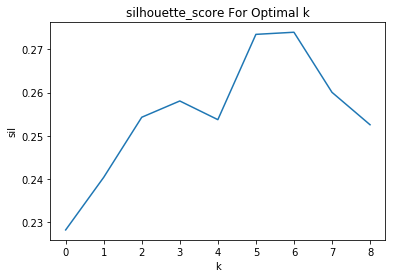

In [30]:
#Method 2 : silhouette score

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

bsas_grouped_clustering = bsas_competitors.drop('Neighborhood', 1)
sil = []
kmax = 10

# minimum number of clusters should be 2
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k, random_state=5).fit(bsas_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(bsas_grouped_clustering, labels, metric = 'euclidean'))

plt.plot(sil)
plt.xlabel('k')
plt.ylabel('sil')
plt.title('silhouette_score For Optimal k')
plt.show()

In [31]:
# set number of clusters
kclusters = 6

bsas_grouped_clustering = bsas_competitors.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bsas_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 1, 1, 1, 3, 3, 4, 4, 3, 4], dtype=int32)

Merging the clusters in the Toronto Dataframe

In [32]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bsas_merged = bsas_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
bsas_merged = bsas_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

bsas_merged # check the last columns!

,Neighborhood,Population Density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agronomía,8.645,-34.592430,-58.496590,0.0,BBQ Joint,Restaurant,Burger Joint
1,Almagro,33.960,-34.603240,-58.420430,1.0,BBQ Joint,Restaurant,Hot Dog Joint
2,Balvanera,34.950,-34.610110,-58.406020,1.0,Sandwich Place,Hot Dog Joint,BBQ Joint
3,Barracas,10.194,-34.649900,-58.389100,1.0,BBQ Joint,Restaurant,Sandwich Place
4,Belgrano,20.433,-34.561530,-58.457020,3.0,BBQ Joint,Sandwich Place,Beer Bar
5,Boedo,18.662,-34.632280,-58.417790,3.0,Burger Joint,BBQ Joint,Restaurant
6,Caballito,25.830,-34.622620,-58.446220,4.0,Restaurant,Burger Joint,BBQ Joint
7,Chacarita,9.800,-34.583510,-58.452870,4.0,Restaurant,Beer Bar,Sandwich Place
8,Coghlan,14.752,-34.561580,-58.474280,3.0,BBQ Joint,Burger Joint,Restaurant
9,Colegiales,21.922,-34.575020,-58.447770,4.0,Restaurant,Sandwich Place,BBQ Joint


Here i drop the 'San Nicolas' Neighborhood which has no venues 

In [33]:
bsas_merged = bsas_merged.dropna(axis=0)
bsas_merged = bsas_merged.reset_index(drop=True)
bsas_merged

,Neighborhood,Population Density,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agronomía,8.645,-34.59243,-58.496590,0.0,BBQ Joint,Restaurant,Burger Joint
1,Almagro,33.960,-34.60324,-58.420430,1.0,BBQ Joint,Restaurant,Hot Dog Joint
2,Balvanera,34.950,-34.61011,-58.406020,1.0,Sandwich Place,Hot Dog Joint,BBQ Joint
3,Barracas,10.194,-34.64990,-58.389100,1.0,BBQ Joint,Restaurant,Sandwich Place
4,Belgrano,20.433,-34.56153,-58.457020,3.0,BBQ Joint,Sandwich Place,Beer Bar
5,Boedo,18.662,-34.63228,-58.417790,3.0,Burger Joint,BBQ Joint,Restaurant
6,Caballito,25.830,-34.62262,-58.446220,4.0,Restaurant,Burger Joint,BBQ Joint
7,Chacarita,9.800,-34.58351,-58.452870,4.0,Restaurant,Beer Bar,Sandwich Place
8,Coghlan,14.752,-34.56158,-58.474280,3.0,BBQ Joint,Burger Joint,Restaurant
9,Colegiales,21.922,-34.57502,-58.447770,4.0,Restaurant,Sandwich Place,BBQ Joint


Showing the clusters in the map

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bsas_merged['Latitude'], bsas_merged['Longitude'], bsas_merged['Neighborhood'], bsas_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [35]:
bsas_merged.loc[bsas_merged['Cluster Labels'] == 0, bsas_merged.columns[[0] + list(range(5, bsas_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Agronomía,BBQ Joint,Restaurant,Burger Joint
14,La Paternal,BBQ Joint,Restaurant,Sandwich Place
16,Mataderos,BBQ Joint,Restaurant,Sandwich Place
20,Núñez,BBQ Joint,Restaurant,Beer Bar
24,Parque Chas,BBQ Joint,Restaurant,Burger Joint
34,Villa Crespo,BBQ Joint,Restaurant,Beer Bar
40,Villa Ortúzar,Restaurant,BBQ Joint,Burger Joint
44,Villa Santa Rita,Restaurant,BBQ Joint,Burger Joint


In [36]:
bsas_merged.loc[bsas_merged['Cluster Labels'] == 1, bsas_merged.columns[[0] + list(range(5, bsas_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
1,Almagro,BBQ Joint,Restaurant,Hot Dog Joint
2,Balvanera,Sandwich Place,Hot Dog Joint,BBQ Joint
3,Barracas,BBQ Joint,Restaurant,Sandwich Place
13,La Boca,BBQ Joint,Restaurant,Sandwich Place
22,Parque Avellaneda,Restaurant,BBQ Joint,Sandwich Place
27,Recoleta,American Restaurant,BBQ Joint,Restaurant
29,Saavedra,BBQ Joint,Restaurant,Sandwich Place
43,Villa Riachuelo,BBQ Joint,Restaurant,Sandwich Place
45,Villa Soldati,BBQ Joint,Restaurant,Sandwich Place


In [37]:
bsas_merged.loc[bsas_merged['Cluster Labels'] == 2, bsas_merged.columns[[0] + list(range(5, bsas_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
15,Liniers,Sandwich Place,Burger Joint,Fast Food Restaurant
18,Monte Castro,Sandwich Place,Fast Food Restaurant,Restaurant
33,Versalles,Fast Food Restaurant,Restaurant,Sandwich Place
38,Villa Lugano,Fast Food Restaurant,BBQ Joint,Restaurant
42,Villa Real,Fast Food Restaurant,Sandwich Place,Burger Joint


In [38]:
bsas_merged.loc[bsas_merged['Cluster Labels'] == 3, bsas_merged.columns[[0] + list(range(5, bsas_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
4,Belgrano,BBQ Joint,Sandwich Place,Beer Bar
5,Boedo,Burger Joint,BBQ Joint,Restaurant
8,Coghlan,BBQ Joint,Burger Joint,Restaurant
10,Constitución,Sandwich Place,BBQ Joint,Beer Bar
21,Palermo,Beer Bar,BBQ Joint,Restaurant
26,Puerto Madero,BBQ Joint,Sandwich Place,Burger Joint
30,San Cristóbal,Sandwich Place,BBQ Joint,Restaurant
31,San Telmo,BBQ Joint,Beer Bar,Restaurant
37,Villa Gral. Mitre,BBQ Joint,Restaurant,Sandwich Place
39,Villa Luro,BBQ Joint,Sandwich Place,Burger Joint


In [39]:
bsas_merged.loc[bsas_merged['Cluster Labels'] == 4, bsas_merged.columns[[0] + list(range(5, bsas_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
6,Caballito,Restaurant,Burger Joint,BBQ Joint
7,Chacarita,Restaurant,Beer Bar,Sandwich Place
9,Colegiales,Restaurant,Sandwich Place,BBQ Joint
11,Flores,Restaurant,BBQ Joint,Sandwich Place
17,Montserrat,Burger Joint,Restaurant,Sandwich Place
23,Parque Chacabuco,Restaurant,Beer Bar,Burger Joint
25,Parque Patricios,Restaurant,Burger Joint,Sandwich Place
28,Retiro,Restaurant,BBQ Joint,Sandwich Place
35,Villa del Parque,Restaurant,Burger Joint,BBQ Joint
36,Villa Devoto,Beer Bar,Restaurant,Burger Joint


In [40]:
bsas_merged.loc[bsas_merged['Cluster Labels'] == 5, bsas_merged.columns[[0] + list(range(5, bsas_merged.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
12,Floresta,BBQ Joint,Restaurant,Sandwich Place
19,Nueva Pompeya,BBQ Joint,Fast Food Restaurant,Restaurant
32,Vélez Sarsfield,BBQ Joint,Restaurant,Sandwich Place
41,Villa Pueyrredón,BBQ Joint,Restaurant,Fast Food Restaurant


Last but not least, im going to sort the wiki df so that we can clearly see the Neighborhoods with the Higher Popultation Density

In [41]:
df_pop = df_wiki.sort_values('Population Density',ascending=False)
df_pop

,Neighborhood,Population Density,Latitude,Longitude
27,Recoleta,34.959,-34.587540,-58.397170
2,Balvanera,34.950,-34.610110,-58.406020
1,Almagro,33.960,-34.603240,-58.420430
24,Parque Chas,28.195,-34.584130,-58.478140
6,Caballito,25.830,-34.622620,-58.446220
30,San Cristóbal,23.803,-34.623700,-58.401490
35,Villa Crespo,23.647,-34.596690,-58.442250
9,Colegiales,21.922,-34.575020,-58.447770
10,Constitución,21.838,-34.621210,-58.386550
4,Belgrano,20.433,-34.561530,-58.457020


## Conclusion

We end up with six clusters that i define as the following

Cluster 1: The most common venues are BBQ Joint and Restaurants.

Cluster 2: The most common venues are BBQ Joint, Restaurants and Sandwich Places.

Cluster 3: The most common venues are Fast Food Restaurants and Sandwich Places.

Cluster 4: The most common venues are BBQ Joints and Sandwich Places.

Cluster 5: The most common venues are Restaurants and Burger/Beer Bars.

Cluster 6: The most common venues are BBQ Joints.

Having these information we can clearly say that Cluster 1 and Cluster 6 are the best places to locate the new McDonald's Franchise. If i'd have to choose one Neighborhood from either of these clusters i would choose 'Parque Chas' because it's the neighborhood with the higher Population Density.